Using this data, your task will be to predict the prices of the houses.

To complete this assignment, create a Jupyter notebook containing your solutions to the following tasks:

1. Load the dataset from the Thinkful PostgreSQL database. You can look at the example above for inspiration on how to generate the database engine URL. You'll need the following values:

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

Please follow the example above and call engine.dispose() when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections, and the database only supports a limited number of connections.

2. Investigate the data, and do any necessary data cleaning.
3. Explore the data and find some variables that you think would be useful in predicting house prices.
4. Build your initial model using these features and estimate the parameters using OLS.

## Load Data

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
# Load data from PostgreSQL database and print out
# observations
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_df = pd.read_sql_query('select * from houseprices',con=engine)

# No need for an open connection, as we're only doing a single query
engine.dispose()

In [3]:
house_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


## Explore and Clean Data

In [4]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

Background info from Kaggle:

1. SalePrice: the property's sale price in dollars. This is the target variable that you're trying to predict.
2. MSSubClass: The building class
3. MSZoning: The general zoning classification
4. LotFrontage: Linear feet of street connected to property
5. LotArea: Lot size in square feet
6. Street: Type of road access
7. Alley: Type of alley access
8. LotShape: General shape of property
9. LandContour: Flatness of the property
10. Utilities: Type of utilities available
11. LotConfig: Lot configuration
12. LandSlope: Slope of property
13. Neighborhood: Physical locations within Ames city limits
14. Condition1: Proximity to main road or railroad
15. Condition2: Proximity to main road or railroad (if a second is present)
16. BldgType: Type of dwelling
17. HouseStyle: Style of dwelling
18. OverallQual: Overall material and finish quality
19. OverallCond: Overall condition rating
20. YearBuilt: Original construction date
21. YearRemodAdd: Remodel date
22. RoofStyle: Type of roof
23. RoofMatl: Roof material
24. Exterior1st: Exterior covering on house
25. Exterior2nd: Exterior covering on house (if more than one material)
26. MasVnrType: Masonry veneer type
27. MasVnrArea: Masonry veneer area in square feet
28. ExterQual: Exterior material quality
29. ExterCond: Present condition of the material on the exterior
30. Foundation: Type of foundation
31. BsmtQual: Height of the basement
32. BsmtCond: General condition of the basement
33. BsmtExposure: Walkout or garden level basement walls
34. BsmtFinType1: Quality of basement finished area
35. BsmtFinSF1: Type 1 finished square feet
36. BsmtFinType2: Quality of second finished area (if present)
37. BsmtFinSF2: Type 2 finished square feet
38. BsmtUnfSF: Unfinished square feet of basement area
39. TotalBsmtSF: Total square feet of basement area
40. Heating: Type of heating
41. HeatingQC: Heating quality and condition
42. CentralAir: Central air conditioning
43. Electrical: Electrical system
44. 1stFlrSF: First Floor square feet
45. 2ndFlrSF: Second floor square feet
46. LowQualFinSF: Low quality finished square feet (all floors)
47. GrLivArea: Above grade (ground) living area square feet
48. BsmtFullBath: Basement full bathrooms
49. BsmtHalfBath: Basement half bathrooms
50. FullBath: Full bathrooms above grade
51. HalfBath: Half baths above grade
52. Bedroom: Number of bedrooms above basement level
53. Kitchen: Number of kitchens
54. KitchenQual: Kitchen quality
55. TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
56. Functional: Home functionality rating
57. Fireplaces: Number of fireplaces
58. FireplaceQu: Fireplace quality
59. GarageType: Garage location
60. GarageYrBlt: Year garage was built
61. GarageFinish: Interior finish of the garage
62. GarageCars: Size of garage in car capacity
63. GarageArea: Size of garage in square feet
64. GarageQual: Garage quality
65. GarageCond: Garage condition
66. PavedDrive: Paved driveway
67. WoodDeckSF: Wood deck area in square feet
68. OpenPorchSF: Open porch area in square feet
69. EnclosedPorch: Enclosed porch area in square feet
70. 3SsnPorch: Three season porch area in square feet
71. ScreenPorch: Screen porch area in square feet
72. PoolArea: Pool area in square feet
73. PoolQC: Pool quality
74. Fence: Fence quality
75. MiscFeature: Miscellaneous feature not covered in other categories
76. MiscVal: $Value of miscellaneous feature
77. MoSold: Month Sold
78. YrSold: Year Sold
79. SaleType: Type of sale
80. SaleCondition: Condition of sale

The following variables seem the most likely to be related to sale price:

1. lotarea
2. neighborhood
3. overallqual
4. overallcond
5. yearbuilt
6. bsmtcond
7. totalbsmtsf
8. heatingqc
9. grlivarea
10. bedroomabvgr
11. kitchenqual
12. functional
13. fullbath
14. garagearea
15. garagequal
16. garagecond
17. poolqc
18. street

In [5]:
columns_of_interest = ['lotarea', 'street', 'neighborhood', 'overallqual',
                       'overallcond', 'yearbuilt', 'bsmtcond',
                       'totalbsmtsf', 'heatingqc', 'grlivarea',
                       'bedroomabvgr', 'kitchenqual', 'functional',
                       'fullbath', 'garagearea', 'garagequal',
                       'garagecond', 'poolqc']

In [6]:
house_df[columns_of_interest].describe()

,lotarea,overallqual,overallcond,yearbuilt,totalbsmtsf,grlivarea,bedroomabvgr,fullbath,garagearea
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,10516.828082,6.099315,5.575342,1971.267808,1057.429452,1515.463699,2.866438,1.565068,472.980137
std,9981.264932,1.382997,1.112799,30.202904,438.705324,525.480383,0.815778,0.550916,213.804841
min,1300.000000,1.000000,1.000000,1872.000000,0.000000,334.000000,0.000000,0.000000,0.000000
25%,7553.500000,5.000000,5.000000,1954.000000,795.750000,1129.500000,2.000000,1.000000,334.500000
50%,9478.500000,6.000000,5.000000,1973.000000,991.500000,1464.000000,3.000000,2.000000,480.000000
75%,11601.500000,7.000000,6.000000,2000.000000,1298.250000,1776.750000,3.000000,2.000000,576.000000
max,215245.000000,10.000000,9.000000,2010.000000,6110.000000,5642.000000,8.000000,3.000000,1418.000000


In [7]:
house_df[columns_of_interest].dtypes

lotarea          int64
street          object
neighborhood    object
overallqual      int64
overallcond      int64
yearbuilt        int64
bsmtcond        object
totalbsmtsf      int64
heatingqc       object
grlivarea        int64
bedroomabvgr     int64
kitchenqual     object
functional      object
fullbath         int64
garagearea       int64
garagequal      object
garagecond      object
poolqc          object
dtype: object

In [8]:
house_df[columns_of_interest].nunique()

lotarea         1073
street             2
neighborhood      25
overallqual       10
overallcond        9
yearbuilt        112
bsmtcond           4
totalbsmtsf      721
heatingqc          5
grlivarea        861
bedroomabvgr       8
kitchenqual        4
functional         7
fullbath           4
garagearea       441
garagequal         5
garagecond         5
poolqc             3
dtype: int64

In [9]:
# Calculate percent missing values
total_missing = house_df.isnull().sum().sort_values(ascending=False)
percent_missing = (house_df.isnull().sum()/house_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


Based on the high percentage of missing values, I will not use poolqc moving forward.

In [10]:
# Split columns of interest into
# categorical and continuous variables
cat_columns = ['street', 'neighborhood', 'overallqual', 'overallcond',
               'bsmtcond', 'heatingqc', 'bedroomabvgr',
               'kitchenqual', 'functional', 'fullbath',
               'garagequal', 'garagecond']

cont_columns = ['lotarea', 'yearbuilt', 'totalbsmtsf',
               'grlivarea', 'garagearea']

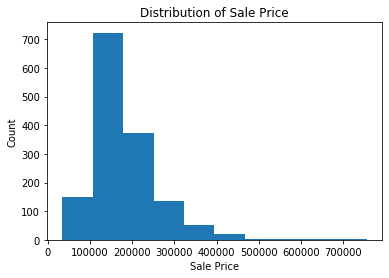

In [11]:
# Look at distribution of target variable: sale price
plt.hist(house_df['saleprice'])
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Count')

plt.show()

Sale price is not normally distributed, but rather skewed to the right.

## Select Features

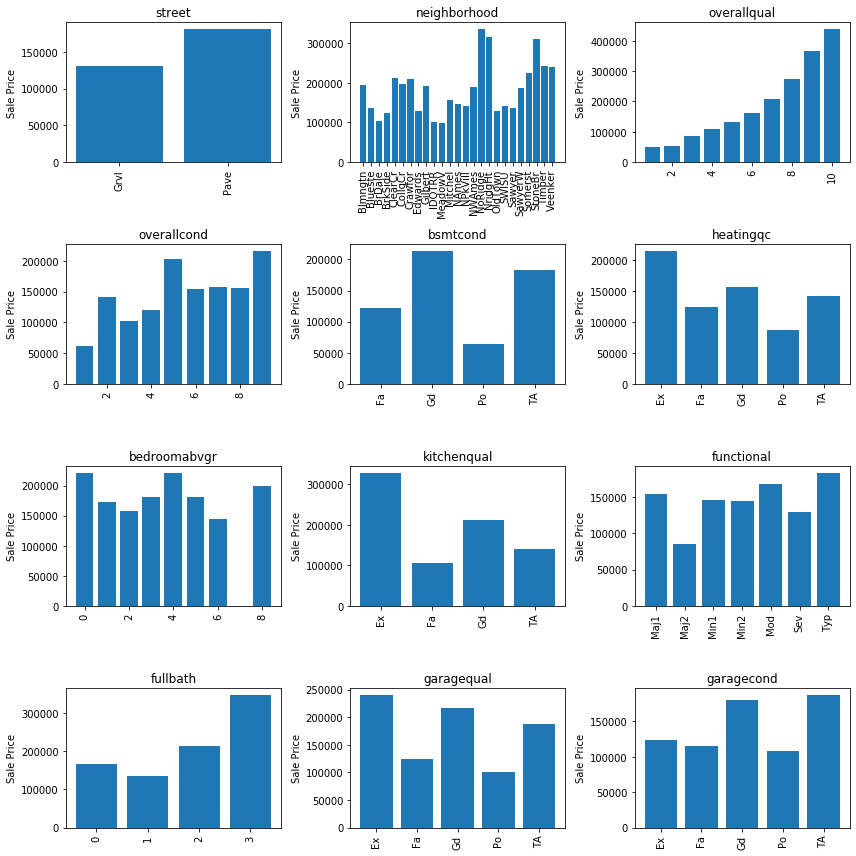

In [12]:
# Look at relationship between sale price and 
# categorical variables using barplot
plt.figure(figsize=(12, 12))

for i, column in enumerate(cat_columns):
    plt.subplot(4, 3, i + 1)
    plt.bar(house_df.groupby(column)['saleprice'].mean().index,
            house_df.groupby(column)['saleprice'].mean())
    plt.title(cat_columns[i])
    plt.ylabel('Sale Price')
    plt.xticks(rotation=90)
    
plt.tight_layout()
plt.show()

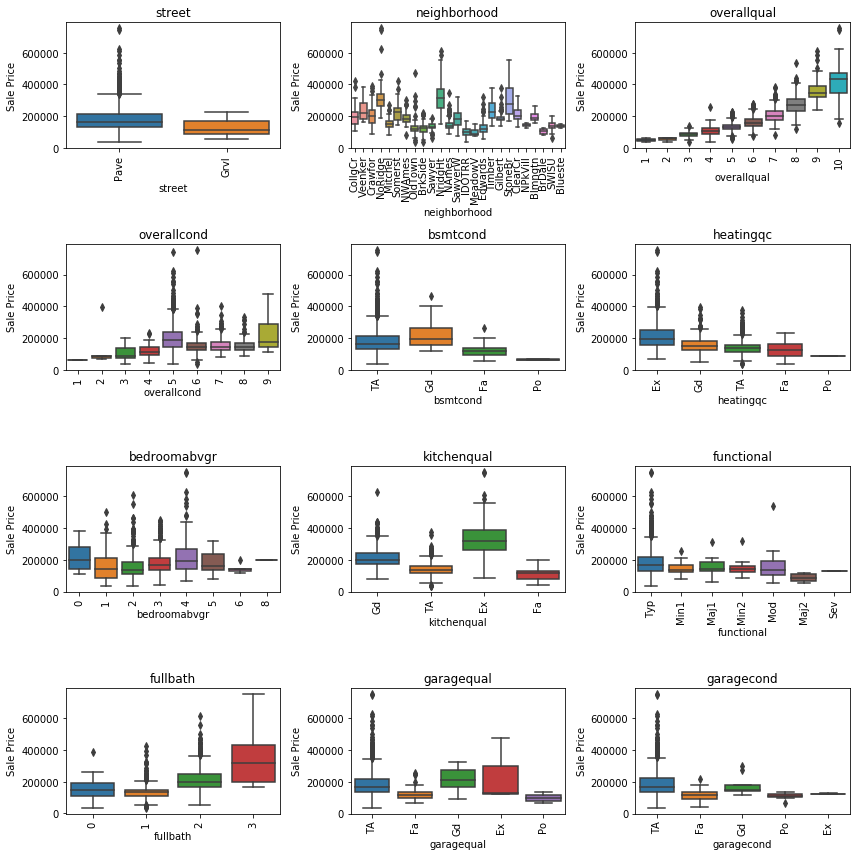

In [13]:
# Look at relationship between sale price and 
# categorical variables using boxplot
plt.figure(figsize=(12, 12))

for i, column in enumerate(cat_columns):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x=column, y='saleprice', data=house_df)
    plt.title(cat_columns[i])
    plt.ylabel('Sale Price')
    plt.xticks(rotation=90)
    
plt.tight_layout()
plt.show()

Key Observations:
1. Houses with street of pave sell for more, on average.
2. Houses in the NoRidge, NridgHt, and StoneBr neighborhoods sell for more, on average.
3. Sale price increases with overallqual.
4. Relationship with overallcond is unclear.
5. Houses with bsmtcond of average (TA) or Gd (good) sell for more, on average.
6. Houses with heatingqc of Ex (excellent) sell for more, on average.
7. Relationship with bedroomabvgr is unclear.
8. Houses with kitchenqual of Ex and Gd sell for more, on average.
9. Houses with functional of Maj2 (major deductions 2) sell for less, on average.
10. Houses with fullbath of 3 sell for more, on average.
11. Houses with garagequal of Ex, Gd, and TA sell for more, on average.
12. Houses with garagecond of Gd and TA sell for more, on average.

Of the categorical variables of interest, I will use street and overallqual as features in my model.

In [14]:
# Convert street and overallqual to numerical variables
house_df['street_is_paved'] = np.where(house_df['street'] == 'Pave', 1, 0)
house_df['overallqual_above_6'] = np.where(house_df['overallqual'] > 6, 1, 0)

house_df[['id', 'street', 'street_is_paved', 'overallqual', 'overallqual_above_6']].head(25)

,id,street,street_is_paved,overallqual,overallqual_above_6
0,1,Pave,1,7,1
1,2,Pave,1,6,0
2,3,Pave,1,7,1
3,4,Pave,1,7,1
4,5,Pave,1,8,1
5,6,Pave,1,5,0
6,7,Pave,1,8,1
7,8,Pave,1,7,1
8,9,Pave,1,7,1
9,10,Pave,1,5,0


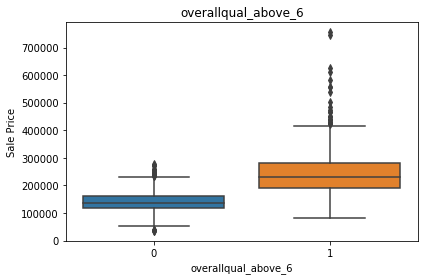

In [15]:
# Look at relationship between sale price and 
# overallqual_above_6 using boxplot
sns.boxplot(x='overallqual_above_6', y='saleprice', data=house_df)
plt.title('overallqual_above_6')
plt.ylabel('Sale Price')
    
plt.tight_layout()
plt.show()

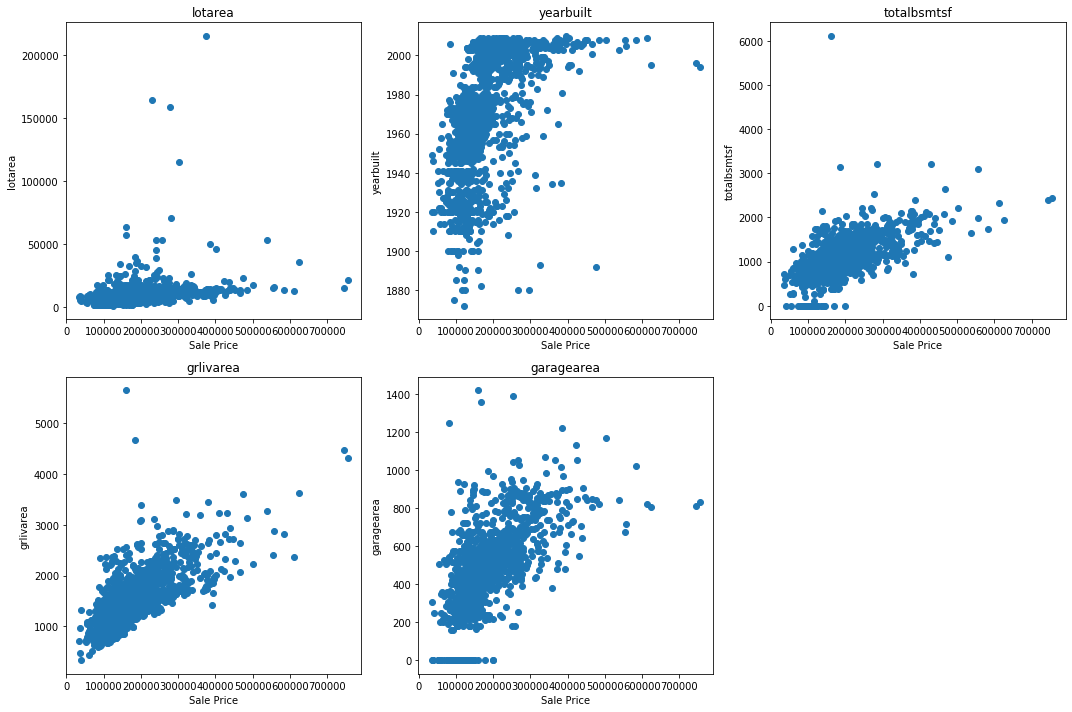

In [16]:
# Look at relationship between sale price and 
# continuous variables
plt.figure(figsize=(15, 10))

for i, column in enumerate(cont_columns):
    plt.subplot(2, 3, i + 1)
    plt.scatter(house_df['saleprice'], house_df[column])
    plt.title(cont_columns[i])
    plt.xlabel('Sale Price')
    plt.ylabel(cont_columns[i])
    
plt.tight_layout()
plt.show()

Key Observations:

1. lotarea, totalbsmtsf, grlivarea, and garagearea are positively correlated with sale price.
2. The relationship between saleprice and yearbuilt is not as clear.

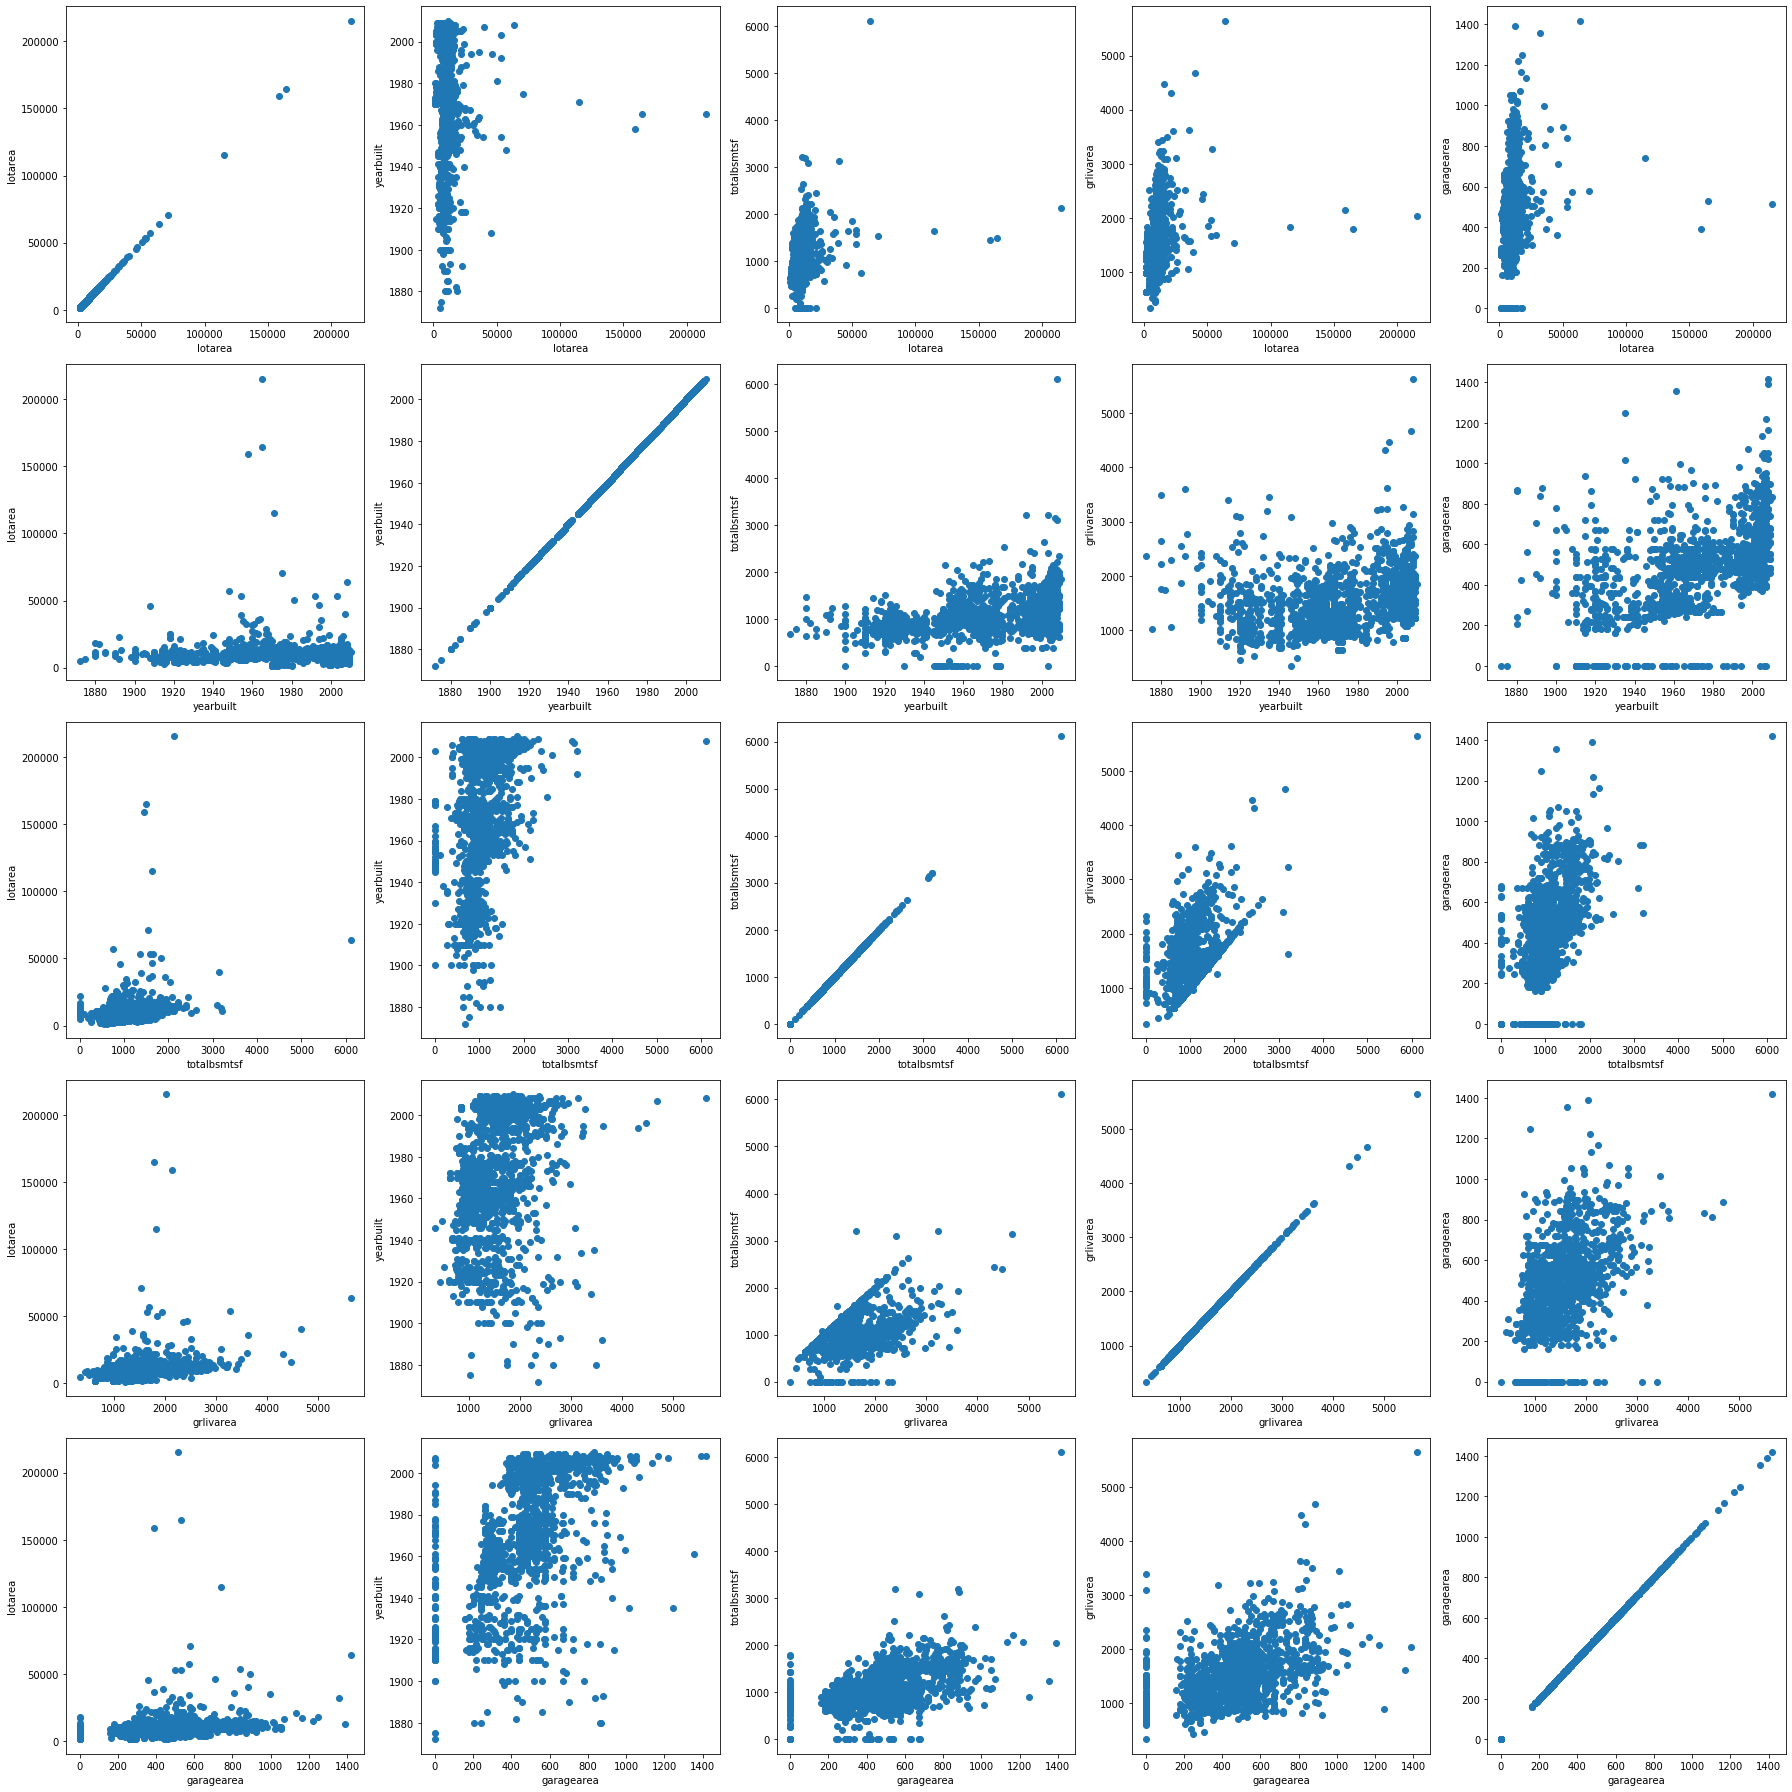

In [17]:
# Look at correlation between five continuous
# variables of interest
plt.figure(figsize=(25, 25))
ticker = 0

for i, x in enumerate(cont_columns):
    for j, y in enumerate(cont_columns):
        ticker += 1
        plt.subplot(5, 5, ticker)
        plt.scatter(house_df[x], house_df[y])
        plt.xlabel(cont_columns[i])
        plt.ylabel(cont_columns[j]) 

plt.tight_layout()
plt.show()

Do not see any strong correlations between lotarea, totalbsmtsf, grlivarea, and garagearea, so I will use all four variables as features in my model.

## Build Model

In [21]:
# Use statsmodel to make linear regression model
X = house_df[['street_is_paved', 'overallqual_above_6', 'lotarea', 'totalbsmtsf', 'grlivarea', 'garagearea']]
Y = house_df.saleprice

# Manually add constant
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     618.5
Date:                Wed, 25 Dec 2019   Prob (F-statistic):               0.00
Time:                        06:40:30   Log-Likelihood:                -17618.
No. Observations:                1460   AIC:                         3.525e+04
Df Residuals:                    1453   BIC:                         3.529e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -3.904e+04   1.82e+04     -2.151      0.032   -7.46e+04   -3437.927
street_is_paved      3.872e+04   1.78e+04      2.178      0.030    3847.798    7.36e+04
overallqual_above_6  4.742e+04   2830.163     16.755      0.000    4.19e+04     5.3e+04
lotarea                 0.4752      0.120      3.967      0.000       0.240       0.710
totalbsmtsf            40.0037      3.092     12.937      0.000      33.938      46.069
grlivarea              53.5868      2.666     20.102      0.000      48.358      58.816
garagearea             74.1952      6.519     11.382      0.000      61.408      86.982
==============================================================================
Omnibus:                      546.237   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61601.254
Skew:                          -0.719   Prob(JB):                         0.00
Kurtosis:                      34.789   Cond. No.                     3.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""